In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from beiming_common import *
%matplotlib inline
import seaborn as sns

In [3]:
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, log_loss, auc, roc_curve, mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [4]:
%%time
trn = pd.read_feather('trn')
val = pd.read_feather('val')

CPU times: user 4.79 s, sys: 10.2 s, total: 15 s
Wall time: 40.6 s


In [5]:
trn.shape

(12961440, 46)

In [6]:
trn['est_dist'] = np.log1p(trn['est_dist'])
val['est_dist'] = np.log1p(val['est_dist'])

In [7]:
display_all(trn.head())

,tripduration,Temp_high,Temp_avg,Temp_low,Precip,est_dist,temp_diff,snow_plus_1,gender_mean_enc,gender_std_enc,starthour_mean_enc,starthour_std_enc,weekday_mean_enc,weekday_std_enc,start station id_mean_enc,start station id_std_enc,end station id_mean_enc,end station id_std_enc,weekend_mean_enc,weekend_std_enc,month_mean_enc,month_std_enc,Rain_mean_enc,Rain_std_enc,Snow_mean_enc,Snow_std_enc,Fog_mean_enc,Fog_std_enc,rain_vol_mean_enc,rain_vol_std_enc,temp_level_mean_enc,temp_level_std_enc,start_cluster_mean_enc,start_cluster_std_enc,end_cluster_mean_enc,end_cluster_std_enc,user_enc_mean_enc,user_enc_std_enc,off_work_mean_enc,off_work_std_enc,snow_plus_1_mean_enc,snow_plus_1_std_enc,age_group_mean_enc,age_group_std_enc,dist_group_mean_enc,dist_group_std_enc
0,6.739337,70,63,56,0.09,8.003363,-3,0,6.474443,0.687611,6.329964,0.737178,6.502080,0.752799,6.636288,0.666697,6.908596,0.560284,6.505435,0.748308,6.460098,0.719749,6.382563,0.717934,6.410285,0.720709,6.409599,0.720464,6.389451,0.715055,6.438768,0.722130,6.379680,0.674114,6.365921,0.671175,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,6.746486,0.370500
1,5.993961,74,63,51,0.00,7.196687,2,0,6.311982,0.708584,6.443064,0.737526,6.384463,0.711508,6.253448,0.688141,6.296133,0.611598,6.377969,0.709001,6.325141,0.716738,6.416588,0.721228,6.410285,0.720709,6.409599,0.720464,6.421399,0.722291,6.438768,0.722130,6.379680,0.674114,6.287242,0.651744,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,6.064984,0.456506
2,6.563856,76,67,57,0.01,7.675546,-3,0,6.311982,0.708584,6.357715,0.729703,6.384463,0.711508,6.300130,0.694324,6.375100,0.806395,6.377969,0.709001,6.460098,0.719749,6.416588,0.721228,6.410285,0.720709,6.409599,0.720464,6.402176,0.716659,6.476009,0.722570,6.377380,0.755415,6.386540,0.758747,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,6.391882,0.407452
3,6.180017,77,71,64,0.11,7.708411,-5,0,6.311982,0.708584,6.431937,0.743573,6.508737,0.743847,6.375959,0.647910,6.320960,0.697721,6.505435,0.748308,6.470666,0.725101,6.382563,0.717934,6.410285,0.720709,6.409599,0.720464,6.389451,0.715055,6.476009,0.722570,6.356166,0.679597,6.424941,0.696973,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,6.391882,0.407452
4,6.001415,52,44,34,0.00,7.554859,9,0,6.311982,0.708584,6.423421,0.715790,6.376942,0.705802,6.325896,0.650938,6.345532,0.641355,6.377969,0.709001,6.261284,0.682873,6.416588,0.721228,6.410285,0.720709,6.409599,0.720464,6.421399,0.722291,6.264907,0.697596,6.299158,0.659189,6.487339,0.618557,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,6.391882,0.407452


In [8]:
%%time
from sklearn.preprocessing import MinMaxScaler

data = trn[['Temp_high', 'Temp_avg', 'Temp_low', 'temp_diff']]#.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(data)


CPU times: user 5.14 s, sys: 15.8 s, total: 20.9 s
Wall time: 23.6 s


In [9]:
trn[['Temp_high', 'Temp_avg', 'Temp_low', 'temp_diff']] = scaler.transform(data)

In [10]:
val[['Temp_high', 'Temp_avg', 'Temp_low', 'temp_diff']] = scaler.transform(val[['Temp_high', 'Temp_avg', 'Temp_low', 'temp_diff']] )

In [11]:
val.head()

,tripduration,Temp_high,Temp_avg,Temp_low,Precip,est_dist,temp_diff,snow_plus_1,gender_mean_enc,gender_std_enc,...,user_enc_mean_enc,user_enc_std_enc,off_work_mean_enc,off_work_std_enc,snow_plus_1_mean_enc,snow_plus_1_std_enc,age_group_mean_enc,age_group_std_enc,dist_group_mean_enc,dist_group_std_enc
0,7.037906,0.828947,0.830986,0.814286,0.0,8.187577,0.641509,0,6.311982,0.708584,...,7.027676,0.552210,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,6.746486,0.370500
1,7.444833,0.855263,0.859155,0.842857,0.0,8.636752,0.547170,0,6.311982,0.708584,...,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,7.134718,0.316551
2,7.454720,0.697368,0.732394,0.757143,0.0,8.789812,0.528302,0,6.311982,0.708584,...,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,7.134718,0.316551
3,7.056175,0.657895,0.619718,0.585714,0.0,5.493061,0.603774,0,6.311982,0.708584,...,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.390670,0.706385,5.364905,0.826955
4,6.577861,0.618421,0.591549,0.557143,0.0,7.889834,0.622642,0,6.311982,0.708584,...,6.340716,0.704413,6.409396,0.720069,6.410832,0.720703,6.347784,0.706758,6.746486,0.370500


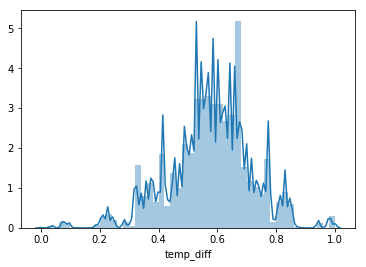

In [12]:
sns.distplot(val['temp_diff'], bins = 50);

In [13]:
%%time
y_train = trn['tripduration']
y_val = val['tripduration']

X_train = trn.drop(['tripduration'], 1)
X_val = val.drop(['tripduration'], 1)

CPU times: user 8.28 s, sys: 16.6 s, total: 24.9 s
Wall time: 29.1 s


In [14]:
del trn, val

In [15]:
rf = RandomForestRegressor(n_jobs=-1, min_samples_leaf=10, 
                           max_features='sqrt', min_samples_split=3, 
                           n_estimators=40)

In [16]:
%%time
rf.fit(X_train, y_train)

CPU times: user 1h 31min 56s, sys: 40.4 s, total: 1h 32min 37s
Wall time: 12min 34s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
%%time
pred_trn = rf.predict(X_train)
pred = rf.predict(X_val)

print('Training loss:', mean_squared_error(y_train, pred_trn) )
print('Validation loss:', mean_squared_error(y_val, pred) )

Training loss: 0.0942836289259
Validation loss: 0.118486892319
CPU times: user 10min 6s, sys: 32.6 s, total: 10min 39s
Wall time: 2min


# LGBM

In [18]:
%%time
print("Training and predicting models...")
params = {
    'num_leaves': 80,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.3,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 8
}

MAX_ROUNDS = 4000
train_pred = []
val_pred = []
test_pred = []
cate_vars = []


print("=" * 60)
dtrain = lgb.Dataset(
    X_train, label=y_train
)
dval = lgb.Dataset(
    X_val, label=y_val, reference=dtrain,
)
bst = lgb.train(
    params, dtrain, num_boost_round=MAX_ROUNDS,
    valid_sets=[dtrain, dval], early_stopping_rounds=100, verbose_eval=100
)


train_pred.append(bst.predict(
    X_train, num_iteration=bst.best_iteration or MAX_ROUNDS))
val_pred.append(bst.predict(
    X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))

Training and predicting models...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.128727	valid_1's l2: 0.129263
[200]	training's l2: 0.123741	valid_1's l2: 0.124728
[300]	training's l2: 0.121111	valid_1's l2: 0.122598
[400]	training's l2: 0.119084	valid_1's l2: 0.121146
[500]	training's l2: 0.117523	valid_1's l2: 0.120088
[600]	training's l2: 0.116164	valid_1's l2: 0.119271
[700]	training's l2: 0.115007	valid_1's l2: 0.118618
[800]	training's l2: 0.113993	valid_1's l2: 0.118121
[900]	training's l2: 0.113112	valid_1's l2: 0.117703
[1000]	training's l2: 0.112299	valid_1's l2: 0.117414
[1100]	training's l2: 0.111512	valid_1's l2: 0.117099
[1200]	training's l2: 0.110814	valid_1's l2: 0.116833
[1300]	training's l2: 0.110178	valid_1's l2: 0.116644
[1400]	training's l2: 0.109518	valid_1's l2: 0.116455
[1500]	training's l2: 0.108925	valid_1's l2: 0.116287
[1600]	training's l2: 0.10835	valid_1's l2: 0.116155
[1700]	training's l2: 0.10779	valid_1's l2: 0.116

In [19]:
print('Training loss:', mean_squared_error(y_train, train_pred[0]) )
print('Validation loss:', mean_squared_error(y_val, val_pred[0]) )

Training loss: 0.0995088064416
Validation loss: 0.114659253833


In [20]:
fi = pd.DataFrame({'cols': X_train.columns, 
                   'imp':bst.feature_importance("gain")}).sort_values('imp', ascending=False)
fi = fi[:25]

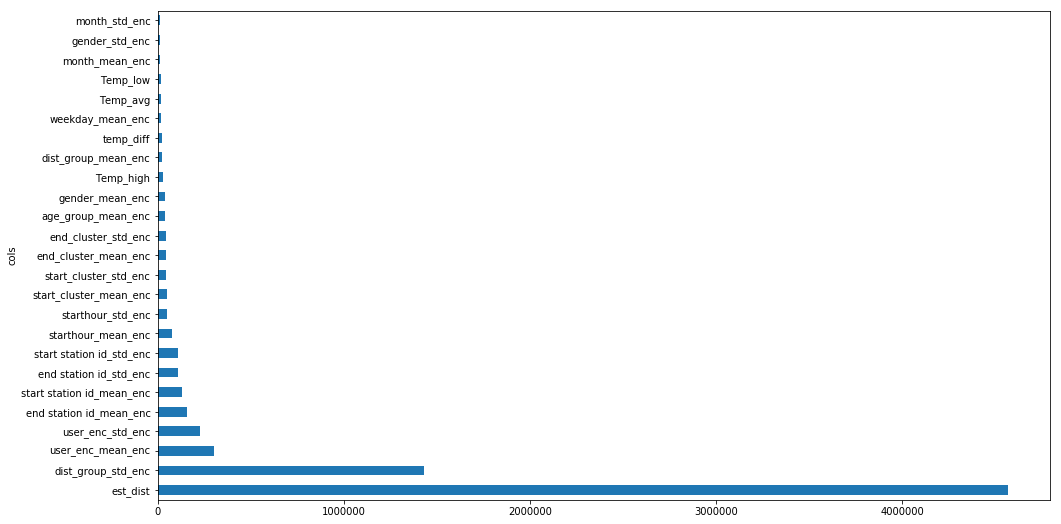

In [21]:
#plt.figure(figsize=(20,20))
fi.plot('cols', 'imp', 'barh', legend=False, figsize=(16,9))

In [23]:
d = pd.DataFrame(y_val)
d['pred'] = val_pred[0]
d.columns = ['y_val', 'pred']
d.head()

,y_val,pred
0,7.037906,7.298517
1,7.444833,7.274317
2,7.454720,7.292883
3,7.056175,5.857837
4,6.577861,6.450442


In [24]:
d['y_val'] = np.exp(d['y_val'])
d['pred'] = np.exp(d['pred'])
d['error'] = (d['pred']-d['y_val'])/d['y_val']


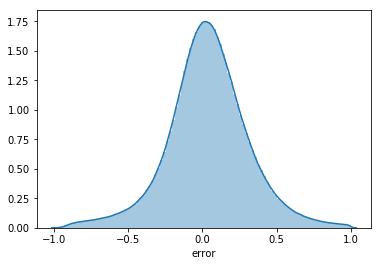

In [28]:
sns.distplot(d['error'][abs(d['error'])<1], bins = 100);

In [35]:
d['90%'] = (abs(d['error']) <= .1)*1
d['80%'] = (abs(d['error']) <= .2)*1
d['70%'] = (abs(d['error']) <= .3)*1
d['60%'] = (abs(d['error']) <= .4)*1

In [36]:
d.mean()

y_val    776.850214
pred     737.405081
error      0.050791
90%        0.330527
80%        0.587811
70%        0.754604
60%        0.853354
dtype: float64